In [1]:
!wget --header="Host: doc-0s-5k-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mt;q=0.8,hi;q=0.7" --header="Cookie: AUTH_2u1gmt4j08s836ujksdlj51vps0jhs16_nonce=45rs822l54fg8" --header="Connection: keep-alive" "https://doc-0s-5k-docs.googleusercontent.com/docs/securesc/6kbudo4ee5hqmlq3ia8ppia9sbcvjuvj/c9cen8ui1eghaa2pst0sed791t6207hg/1634791275000/12878554966299595518/12878554966299595518/1jqMhtzlops8iBUTwYDiIAA2s1JucXd1t?e=download&authuser=0&nonce=45rs822l54fg8&user=12878554966299595518&hash=7t9bp2i6nq3i3hgeis5jshjjmtlk3bnl" -c -O 'df_data.csv'

--2021-10-21 04:41:45--  https://doc-0s-5k-docs.googleusercontent.com/docs/securesc/6kbudo4ee5hqmlq3ia8ppia9sbcvjuvj/c9cen8ui1eghaa2pst0sed791t6207hg/1634791275000/12878554966299595518/12878554966299595518/1jqMhtzlops8iBUTwYDiIAA2s1JucXd1t?e=download&authuser=0&nonce=45rs822l54fg8&user=12878554966299595518&hash=7t9bp2i6nq3i3hgeis5jshjjmtlk3bnl
Resolving doc-0s-5k-docs.googleusercontent.com (doc-0s-5k-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-0s-5k-docs.googleusercontent.com (doc-0s-5k-docs.googleusercontent.com)|74.125.20.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33697872 (32M) [text/csv]
Saving to: ‘df_data.csv’

df_data.csv         100%[===================>]  32.14M   208MB/s    in 0.2s    

2021-10-21 04:41:46 (208 MB/s) - ‘df_data.csv’ saved [33697872/33697872]



In [2]:
#importing libraries
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import seaborn as sns

In [3]:
df_data=pd.read_csv('df_data.csv')
df_data.head()

,questions,answers_inp,answers_out
0,can we make this quick roxanne korrine and and...,<start> well i thought we would start with pro...,well i thought we would start with pronunciati...
1,well i thought we would start with pronunciati...,<start> not the hacking and gagging and spitti...,not the hacking and gagging and spitting part ...
2,not the hacking and gagging and spitting part ...,<start> okay then how bout we try out some fre...,okay then how bout we try out some french cuis...
3,you are asking me out that is so cute what is ...,<start> forget it,forget it <end>
4,the thing is cameron i am at the mercy of a pa...,<start> seems like she could get a date easy e...,seems like she could get a date easy enough <end>


In [4]:
df_data['answers']=[" ".join(i.split()[1:]) for i in df_data['answers_inp'].values]

In [5]:
df_data['complete_answers']=df_data['answers_inp']+' <end>'

In [6]:
labels_to_remove=[]
for index, value in enumerate(df_data['questions'].values):
     if len(value.split())>25:
         labels_to_remove.append(index)
for index, value in enumerate(df_data['answers'].values):
     if len(value.split())>25:
         labels_to_remove.append(index)
labels_to_remove=list(set(labels_to_remove))

In [7]:
df_new=df_data.drop(labels=labels_to_remove).reset_index(drop=True)

In [8]:
#train test split
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df_new, test_size=0.2)

In [9]:
df_new.shape

(154389, 5)

In [10]:
VOCAB_SIZE=10000

In [98]:
token=Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
token.fit_on_texts(train['questions'].values.astype(str))

In [67]:

token.word_index['<start>']=8001
token.word_index['<end>']=8002

In [64]:
decoder_token.word_index['<end>'], decoder_token.word_index['<start>']

(2, 1)

In [14]:
train_encoder_input=encoder_token.texts_to_sequences(train['questions'])
train_decoder_input = decoder_token.texts_to_sequences(train['answers_inp'])
train_decoder_output= decoder_token.texts_to_sequences(train['answers_out'])

validation_encoder_input=encoder_token.texts_to_sequences(validation['questions'])
validation_decoder_input = decoder_token.texts_to_sequences(validation['answers_inp'])
validation_decoder_output= decoder_token.texts_to_sequences(validation['answers_out'])

In [13]:
max_length=25

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_encoder_input=pad_sequences(train_encoder_input, maxlen=max_length, padding='post')
train_decoder_input=pad_sequences(train_decoder_input, maxlen=max_length, padding='post')
train_decoder_output=pad_sequences(train_decoder_output, maxlen=max_length, padding='post')

validation_encoder_input=pad_sequences(validation_encoder_input, maxlen=max_length, padding='post')
validation_decoder_input=pad_sequences(validation_decoder_input, maxlen=max_length, padding='post')
validation_decoder_output=pad_sequences(validation_decoder_output, maxlen=max_length, padding='post')

In [16]:
BUFFER_SIZE=20000
BATCH_SIZE=256
###TRAIN DATASET###
train_dataset=tf.data.Dataset.from_tensor_slices(((train_encoder_input, train_decoder_input),train_decoder_output))
train_dataset=train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


###VALIDATION DATASET###
validation_dataset=tf.data.Dataset.from_tensor_slices(((validation_encoder_input, validation_decoder_input), validation_decoder_output))
validation_dataset=validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.cache()
validation_dataset = validation_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [45]:
train_encoder_input.shape, train_decoder_input.shape,train_decoder_output.shape


((66313, 12), (66313, 12), (66313, 12))

In [11]:
encoder_token=Tokenizer(num_words=VOCAB_SIZE)
encoder_token.fit_on_texts(train['questions'].values.astype(str))
enc_vocab_size=len(encoder_token.word_index.keys())
enc_vocab_size

34331

In [12]:
decoder_token=Tokenizer(num_words=VOCAB_SIZE,filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
decoder_token.fit_on_texts(train['complete_answers'].values.astype(str))
dec_vocab_size=len(decoder_token.word_index.keys())
dec_vocab_size

34322

In [17]:
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Concatenate
class Encoder(tf.keras.layers.Layer):
   '''
   Creation of an encoder class for an encoder-decoder model

   Args:
   enc_vocab_size- inputs the vocabulary size of the sequence to be fed in the encoder
   embedding_size- output dimesion of the embedding layer
   encoder_input_length- length of the sequence

   Returns:
   Returns outputs of all the timesteps, final timestep hidden state, final timestep cell state of the lstm layer

   '''

   def __init__(self,enc_vocab_size, embedding_size,enc_lstm_size,enc_input_length,embedding_weights_available=False):
       super().__init__()
       self.enc_vocab_size=enc_vocab_size
       self.embedding_size=embedding_size
       self.enc_lstm_size=enc_lstm_size
       self.enc_input_length=enc_input_length
       if embedding_weights_available:
            print('using pretrained vector for embedding')
            self.embedding_layer=Embedding(input_dim=self.enc_vocab_size,output_dim=self.embedding_size,weights=[embedding_matrix_encoder],trainable=False,input_length=self.enc_input_length,mask_zero=True,name='embedding_layer_encoder')
       else:
            print('using no pretrained vector for embedding')
            self.embedding_layer=Embedding(input_dim=self.enc_vocab_size,output_dim=self.embedding_size,input_length=self.enc_input_length,trainable=True,mask_zero=True,name='embedding_layer_encoder')

            
       self.lstm_layer1=Bidirectional(LSTM(self.enc_lstm_size,dropout=0.3,return_sequences=True, return_state=True),merge_mode='concat', name='ENCODER_LSTM1')
       self.lstm_layer2=Bidirectional(LSTM(self.enc_lstm_size,dropout=0.3,return_sequences=True, return_state=True),merge_mode='concat', name='ENCODER_LSTM2')
       self.lstm_layer3=Bidirectional(LSTM(self.enc_lstm_size,dropout=0.3,return_sequences=True, return_state=True),merge_mode='concat', name='ENCODER_LSTM3')
   def call(self, input_sequences,training=True):
      enc_embedd=self.embedding_layer(input_sequences)
      enc_whole_seq_output1,forward_h1,forward_c1,backward_h1,backward_c1= self.lstm_layer1(enc_embedd)
      enc_whole_seq_output2,forward_h2,forward_c2,backward_h2,backward_c2= self.lstm_layer2(enc_whole_seq_output1)
      enc_whole_seq_output3,forward_h3,forward_c3,backward_h3,backward_c3= self.lstm_layer3(enc_whole_seq_output1)
      enc_hidden_state1=Concatenate()([forward_h1,backward_h1])
      enc_cell_state1=Concatenate()([backward_h1,backward_c1])

      enc_hidden_state2=Concatenate()([forward_h2,backward_h2])
      enc_cell_state2=Concatenate()([backward_h2,backward_c2])

      enc_hidden_state3=Concatenate()([forward_h3,backward_h3])
      enc_cell_state3=Concatenate()([backward_h3,backward_c3])

      states1=[enc_hidden_state1, enc_cell_state1]
      states2=[enc_hidden_state2, enc_cell_state2]
      states3=[enc_hidden_state3, enc_cell_state3]

      return enc_whole_seq_output1, enc_whole_seq_output2, enc_whole_seq_output3, states1, states2, states3

In [18]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):

    super().__init__()
    # Please go through the reference notebook and research paper to complete the scoring functions
    self.scoring_function=scoring_function
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
       self.att_units=att_units
      
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.att_units=att_units
      self.W=Dense(self.att_units)
    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.att_units=att_units
      self.W_alpha=Dense(self.att_units,activation='tanh')
      self.V=Dense(1)
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
 

   
    decoder_hidden_state=tf.reshape(decoder_hidden_state,shape=(-1,1,decoder_hidden_state.shape[1]))

    if self.scoring_function == 'dot':
        # Implement Dot score function here
       
        attention_weights=tf.matmul(a=encoder_output,b=decoder_hidden_state,transpose_a=False,transpose_b=True)
        
        attention_weights=tf.nn.softmax(attention_weights,axis=1)
       

        context_vector=tf.matmul(a=encoder_output,b=attention_weights,transpose_a=True,transpose_b=False)
        
        context_vector=tf.reshape(context_vector,shape=(-1,encoder_output.shape[2]))
        
        return context_vector,attention_weights
    elif self.scoring_function == 'general':
        # Implement General score function here
        
        attention_weights=tf.matmul(self.W(encoder_output),decoder_hidden_state,transpose_b=True)
        #attention_weights=tf.reshape(attention_weights,shape=(attention_weights.shape[0],attention_weights.shape[2],attention_weights.shape[1]))
      
        attention_weights=tf.nn.softmax(attention_weights,axis=1)
        
        context_vector=tf.matmul(a=encoder_output,b=attention_weights,transpose_a=True,transpose_b=False)
        context_vector=tf.reshape(context_vector,shape=(-1,context_vector.shape[1]))
        return context_vector,attention_weights
        
    elif self.scoring_function == 'concat':
        # Implement General score function here

       attention_weights=self.V(self.W_alpha(tf.add(encoder_output,decoder_hidden_state)))
       attention_weights=tf.nn.softmax(attention_weights,axis=1)
       context_vector=tf.linalg.matmul(a=encoder_output,b=attention_weights,transpose_a=True,transpose_b=False)
       context_vector=tf.reshape(context_vector,shape=(-1,context_vector.shape[1]))
       return context_vector,attention_weights

In [19]:
class OneStepDecoder(tf.keras.layers.Layer):
  def __init__(self,dec_vocab_size, embedding_size, dec_input_length, dec_lstm_size ,score_fun ,att_units,embedding_weights_available):

      # Initialize decoder embedding layer, LSTM and any other objects needed
        super().__init__()
        self.dec_vocab_size=dec_vocab_size
        self.embedding_size=embedding_size
        self.dec_lstm_size= dec_lstm_size
        self.dec_input_length=dec_input_length
        self.score_fun=score_fun
        self.att_units=att_units
      
       
        #self.embedding_matrix=matrix(token,self.out_vocab_size,self.embedding_size)
        if embedding_weights_available:
            self.embedding=Embedding(input_dim=self.dec_vocab_size,output_dim=self.embedding_size,weights=[embedding_matrix_decoder],input_length=self.dec_input_length,mask_zero=True, trainable=False)
        else:
            self.embedding=Embedding(input_dim=self.dec_vocab_size,output_dim=self.embedding_size,input_length=self.dec_input_length,mask_zero=True,trainable=True)
        
        self.lstm1=LSTM(units=self.dec_lstm_size,dropout=0.637803031844477,return_state=True,return_sequences=True, name="DECODER_LSTM1")
        self.lstm2= LSTM(units=self.dec_lstm_size, dropout=0.63, return_state=True, return_sequences=True, name='DECODER_LSTM2')
        self.lstm3= LSTM(units=self.dec_lstm_size, dropout=0.63, return_state=True, return_sequences=True, name='DECODER_LSTM3')
        self.attention=Attention(self.score_fun,self.att_units)
        self.dense=Dense(self.dec_vocab_size)
        
  def call(self,input_to_decoder, encoder_output, states1, states2, states3):
      '''
          One step decoder mechanisim step by step:
        A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        B. Using the encoder_output and decoder hidden state, compute the context vector.
        C. Concat the context vector with the step A output
        D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        F. Return the states from step D, output from Step E, attention weights from Step -B


        states1=[enc_hidden_state1, enc_cell_state1]
      states2=[enc_hidden_state2, enc_cell_state2]
      '''
      dec_embed=self.embedding(input_to_decoder)
     
      context_vector1,attention_weights1=self.attention(decoder_hidden_state=states1[0], encoder_output=encoder_output[0])
      #lstm_layer1
      dec_inp=tf.concat([tf.expand_dims(context_vector1, 1),dec_embed],axis=2)
      decoder_output,decoder_hidden_state1,decoder_cell_state1=self.lstm1(dec_inp,initial_state=states1)

      #lstm_layer2
      context_vector2,attention_weights2=self.attention(decoder_hidden_state=states2[0], encoder_output=encoder_output[1])
      decoder_output=tf.concat([tf.expand_dims(context_vector2, 1),decoder_output],axis=2)
      decoder_output, decoder_hidden_state2, decoder_cell_state2= self.lstm2(decoder_output, initial_state=states2)
      
      #lstm_layer3
      context_vector3,attention_weights3=self.attention(decoder_hidden_state=states3[0], encoder_output=encoder_output[2])
      decoder_output=tf.concat([tf.expand_dims(context_vector3, 1),decoder_output],axis=2)
      decoder_output, decoder_hidden_state3, decoder_cell_state3= self.lstm3(decoder_output, initial_state=states3)
      
      decoder_output=self.dense(decoder_output)

      decoder_output=tf.reshape(decoder_output,shape=(-1,decoder_output.shape[2]))

      states1=[decoder_hidden_state1, decoder_cell_state2]
      states2=[decoder_hidden_state2, decoder_cell_state2]
      states3=[decoder_hidden_state3, decoder_cell_state3]
    
      return decoder_output, states1, states2, states3

In [20]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,dec_vocab_size, embedding_size, dec_input_length, dec_lstm_size ,score_fun ,att_units,embedding_weights_available):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.dec_vocab_size=dec_vocab_size
      self.embedding_size=embedding_size
      self.dec_lstm_size= dec_lstm_size
      self.dec_input_length=dec_input_length
      self.score_fun=score_fun
      self.att_units=att_units
    
     
      self.onestepdecoder=OneStepDecoder(dec_vocab_size=self.dec_vocab_size, embedding_size=self.embedding_size, dec_input_length=self.dec_input_length, dec_lstm_size=self.dec_lstm_size ,score_fun=self.score_fun ,att_units=self.att_units,embedding_weights_available=embedding_weights_available)
    
    def call(self, input_to_decoder,encoder_output,states1, states2, states3 ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
       
        all_outputs=tf.TensorArray(tf.float32,size=self.dec_input_length)
        #all_outputs=[]
        count=0
        #print(input_to_decoder[1].shape)
        for timestep in range(self.dec_input_length):
             #count=count+1
             #print(input_to_decoder.shape[1])
             #print(count)
             decoder_output,states1,states2,states3=self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],encoder_output,states1,states2, states3)
             all_outputs=all_outputs.write(timestep,decoder_output)
            
             #all_outputs.append(decoder_output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs  

In [21]:
class encoder_decoder(tf.keras.Model):

  def __init__(self, enc_vocab_size, dec_vocab_size, embedding_size, enc_lstm_size, dec_lstm_size, enc_input_length, dec_input_length, score_fun, att_units, embedding_weights_available):
    #Intialize objects from encoder decoder
    super().__init__() 
    self.enc_vocab_size=enc_vocab_size
    self.dec_vocab_size=dec_vocab_size
    self.embedding_size=embedding_size
    self.enc_lstm_size=enc_lstm_size
    self.dec_lstm_size=dec_lstm_size
    self.enc_input_length=enc_input_length
    self.dec_input_length=dec_input_length
    self.score_fun=score_fun
    self.att_units=att_units

   


    self.encoder = Encoder(enc_vocab_size=self.enc_vocab_size+1, embedding_size=self.embedding_size, enc_lstm_size=self.enc_lstm_size, enc_input_length=self.enc_input_length, embedding_weights_available=embedding_weights_available)
    self.decoder = Decoder(dec_vocab_size=self.dec_vocab_size+1, embedding_size=self.embedding_size,  dec_input_length=self.dec_input_length, dec_lstm_size=self.dec_lstm_size, score_fun= self.score_fun, att_units=self.att_units, embedding_weights_available=embedding_weights_available)
   # self.dense   = Dense(output_vocab_size, activation='softmax')

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    input,output = data[0], data[1]

    enc_whole_seq_output1, enc_whole_seq_output2, enc_whole_seq_output3, states1, states2, states3 =self.encoder(input)
    encoder_output=[enc_whole_seq_output1, enc_whole_seq_output2, enc_whole_seq_output3]

    decoder_output=self.decoder(output, encoder_output, states1, states2, states3)
    
    return decoder_output

In [22]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [23]:
def custom_lossfunction(targets,logits):

   mask = tf.math.logical_not(tf.math.equal(targets, 0))
   loss_ = loss_object(targets,logits)

   mask = tf.cast(mask, dtype=loss_.dtype)
   loss_ *= mask

   return tf.reduce_mean(loss_)

In [24]:
early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=3, verbose=0,
    mode='min', restore_best_weights=True
)

<h2> MODEL1- no pretrained vector and using function 'dot' for attention</h2>

In [77]:
import warnings
warnings.filterwarnings("ignore")

enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE 

enc_lstm_size=256
dec_lstm_size=512
score_fun='dot'
att_units=512
embedding_weights_available=False
embedding_size=512
enc_input_length=max_length
dec_input_length=max_length
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
#reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.2, patience=2, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
model  = encoder_decoder(enc_vocab_size=enc_vocab_size,dec_vocab_size=dec_vocab_size, embedding_size=embedding_size, enc_lstm_size=enc_lstm_size, dec_lstm_size=dec_lstm_size,  enc_input_length=enc_input_length, dec_input_length=dec_input_length, score_fun=score_fun, att_units=att_units, embedding_weights_available=embedding_weights_available)
optimizer = tf.keras.optimizers.Adam( 0.001,decay=1e-5)
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=['acc'])
#train_steps=train.shape[0]//batch_size
#valid_steps=validation.shape[0]//batch_size

history=model.fit(train_dataset,epochs=100,batch_size=256, validation_data=validation_dataset,callbacks=[reduce_lr,early_stop])
#history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using no pretrained vector for embedding
Epoch 1/100
483/483 [==============================] - 378s 467ms/step - loss: 2.2349 - acc: 0.0469 - val_loss: 2.1754 - val_acc: 0.0477
Epoch 2/100
483/483 [==============================] - 188s 389ms/step - loss: 2.1881 - acc: 0.0485 - val_loss: 2.1692 - val_acc: 0.0488
Epoch 3/100
483/483 [==============================] - 188s 389ms/step - loss: 2.1817 - acc: 0.0489 - val_loss: 2.1630 - val_acc: 0.0491
Epoch 4/100
483/483 [==============================] - 187s 388ms/step - loss: 2.0806 - acc: 0.0562 - val_loss: 1.9452 - val_acc: 0.0664
Epoch 5/100
483/483 [==============================] - 187s 388ms/step - loss: 1.9073 - acc: 0.0716 - val_loss: 1.8430 - val_acc: 0.0769
Epoch 6/100
483/483 [==============================] - 188s 389ms/step - loss: 1.8314 - acc: 0.0783 - val_loss: 1.7956 - val_acc: 0.0813
Epoch 7/100
483/483 [==============================] - 188s 389ms/step - loss: 1.7851 - acc: 0.0817 - val_loss: 1.7666 - val_acc: 0.0835


[]

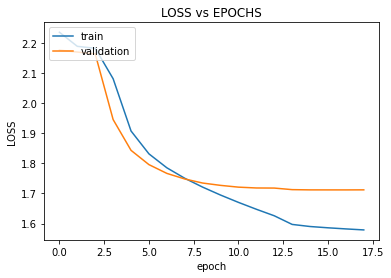

In [78]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

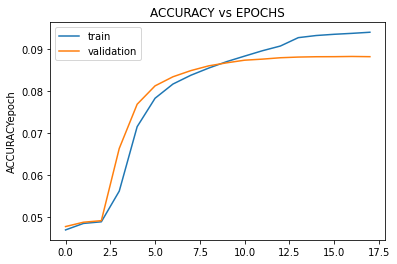

In [79]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [31]:
def greedy_search_predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  attention_plot = np.zeros((10, 10))

  enc_sent=encoder_token.texts_to_sequences(input_sentence)

  padded_enc_sent=pad_sequences(enc_sent,max_length, padding='post')

 

  encoder_embed= model.layers[0].embedding_layer(padded_enc_sent)
  
  enc_whole_seq_output1,forward_h1,forward_c1,backward_h1,backward_c1= model.layers[0].lstm_layer1(encoder_embed)
  enc_whole_seq_output2,forward_h2,forward_c2,backward_h2,backward_c2= model.layers[0].lstm_layer2(enc_whole_seq_output1)
  enc_whole_seq_output3,forward_h3,forward_c3,backward_h3,backward_c3= model.layers[0].lstm_layer3(enc_whole_seq_output2)
      
  enc_hidden_state1=Concatenate()([forward_h1,backward_h1])
  enc_cell_state1=Concatenate()([backward_h1,backward_c1])

  enc_hidden_state2=Concatenate()([forward_h2,backward_h2])
  enc_cell_state2=Concatenate()([backward_h2,backward_c2])

  enc_hidden_state3=Concatenate()([forward_h3,backward_h3])
  enc_cell_state3=Concatenate()([backward_h3,backward_c3])

  states1=[enc_hidden_state1, enc_cell_state1]
  states2=[enc_hidden_state2, enc_cell_state2]
  states3=[enc_hidden_state3, enc_cell_state3]

  

  #encoder_output,forward_h,forward_c,backward_h,backward_c=model.layers[0].lstm1(encoder_embed)

  word_count=0
  pred = []
  
  dec_input= np.array([[8001]])
  #attention_weights_list=[]
  #hidden_state_enc=Concatenate()([forward_h,backward_h])
  #cell_state_enc=Concatenate()([forward_c,backward_c])
  #input_state=[hidden_state_enc,cell_state_enc]
  encoder_output=[enc_whole_seq_output1, enc_whole_seq_output2, enc_whole_seq_output3]
  while (dec_input!=decoder_token.word_index['<end>'] and word_count<=max_length ):
     
       decoder_output, states1, states2, states3=model.layers[1].onestepdecoder(dec_input,encoder_output,states1,states2,states3)
       
      
       dec_input=np.reshape(np.argmax(decoder_output), (1, 1))
       #input_state=[decoder_hidden_state,decoder_cell_state]
     
       for key,value in decoder_token.word_index.items():
   
            if value==dec_input[0]:
                word=key
              
       
     
       pred.append(word)
       word_count=word_count+1
      
  predicted_sentence=" ".join(pred)

 # attention_plot = attention_plot[:len(predicted_sentence.split(' ')), :len(input_sentence[0].split(' '))]
  #plot_attention(attention_plot, input_sentence[0].split(),predicted_sentence.split())
  
  return pred

In [81]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',greedy_search_predict([i]))

question--> hello
BOT--> ['<end>']
question--> how are you
BOT--> ['<end>']
question--> once upon a  time there was a man
BOT--> ['i', 'am', 'sorry', 'i', 'am', 'not', 'going', 'to', 'be', 'a', 'good', 'man', '<end>']
question--> are you sure you will be alright
BOT--> ['<end>']
question--> are you coming with me to London
BOT--> ['i', 'am', 'sorry', 'i', 'am', 'not', 'sure', '<end>']
question--> do you know me
BOT--> ['i', 'am', 'not', 'sure', '<end>']


In [82]:
from  nltk.translate.bleu_score import sentence_bleu
val=train.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
     
     candidate=greedy_search_predict([val['questions'].iloc[i]])
     reference=[val['answers_out'].iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

The average BLEU score of these sentences is 0.36770404745531654


<h2> MODEL2- no pretrained vector and using function 'general' for attention</h2>

In [83]:

enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE 

enc_lstm_size=256
dec_lstm_size=512
score_fun='general'
att_units=512
embedding_weights_available=False
embedding_size=512
enc_input_length=max_length
dec_input_length=max_length
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
#reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.2, patience=2, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
model  = encoder_decoder(enc_vocab_size=enc_vocab_size,dec_vocab_size=dec_vocab_size, embedding_size=embedding_size, enc_lstm_size=enc_lstm_size, dec_lstm_size=dec_lstm_size,  enc_input_length=enc_input_length, dec_input_length=dec_input_length, score_fun=score_fun, att_units=att_units, embedding_weights_available=embedding_weights_available)
optimizer = tf.keras.optimizers.Adam( 0.001,decay=1e-5)
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=['acc'])
#train_steps=train.shape[0]//batch_size
#valid_steps=validation.shape[0]//batch_size

history=model.fit(train_dataset,epochs=100,batch_size=256, validation_data=validation_dataset,callbacks=[reduce_lr,early_stop])
#history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using no pretrained vector for embedding
Epoch 1/100
483/483 [==============================] - 446s 607ms/step - loss: 2.2351 - acc: 0.0470 - val_loss: 2.1750 - val_acc: 0.0484
Epoch 2/100
483/483 [==============================] - 252s 521ms/step - loss: 2.1878 - acc: 0.0487 - val_loss: 2.1678 - val_acc: 0.0489
Epoch 3/100
483/483 [==============================] - 252s 522ms/step - loss: 2.1792 - acc: 0.0489 - val_loss: 2.1605 - val_acc: 0.0489
Epoch 4/100
483/483 [==============================] - 251s 521ms/step - loss: 2.1178 - acc: 0.0524 - val_loss: 2.0266 - val_acc: 0.0574
Epoch 5/100
483/483 [==============================] - 252s 521ms/step - loss: 1.9521 - acc: 0.0669 - val_loss: 1.8655 - val_acc: 0.0751
Epoch 6/100
483/483 [==============================] - 251s 521ms/step - loss: 1.8424 - acc: 0.0774 - val_loss: 1.8002 - val_acc: 0.0811
Epoch 7/100
483/483 [==============================] - 252s 521ms/step - loss: 1.7858 - acc: 0.0814 - val_loss: 1.7661 - val_acc: 0.0836


[]

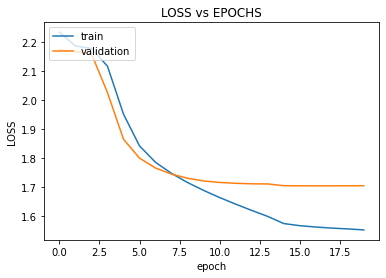

In [84]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

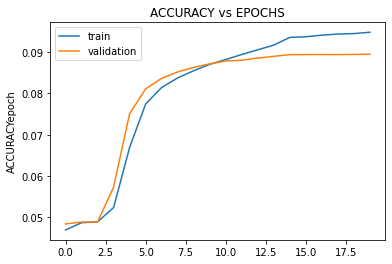

In [85]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [86]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',greedy_search_predict([i]))

question--> hello
BOT--> ['you', 'are', 'going', 'to', 'be', 'a', 'little', '<end>']
question--> how are you
BOT--> ['would', 'not', 'be', 'a', 'good', 'man', '<end>']
question--> once upon a  time there was a man
BOT--> ['i', 'am', 'sorry', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'am', 'sorry', 'i', 'am', 'sorry', '<end>']
question--> are you coming with me to London
BOT--> ['i', 'am', 'sorry', '<end>']
question--> do you know me
BOT--> ['i', 'am', 'sorry', '<end>']


In [87]:
from  nltk.translate.bleu_score import sentence_bleu
val=train.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
     
     candidate=greedy_search_predict([val['questions'].iloc[i]])
     reference=[val['answers_out'].iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

The average BLEU score of these sentences is 0.38021249193544576


<h2> MODEL3- no pretrained vector and using function 'concat' for attention</h2>

In [88]:
enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE 

enc_lstm_size=256
dec_lstm_size=512
score_fun='concat'
att_units=512
embedding_weights_available=False
embedding_size=512
enc_input_length=max_length
dec_input_length=max_length
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
#reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.2, patience=2, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
model  = encoder_decoder(enc_vocab_size=enc_vocab_size,dec_vocab_size=dec_vocab_size, embedding_size=embedding_size, enc_lstm_size=enc_lstm_size, dec_lstm_size=dec_lstm_size,  enc_input_length=enc_input_length, dec_input_length=dec_input_length, score_fun=score_fun, att_units=att_units, embedding_weights_available=embedding_weights_available)
optimizer = tf.keras.optimizers.Adam( 0.001,decay=1e-5)
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=['acc'])
#train_steps=train.shape[0]//batch_size
#valid_steps=validation.shape[0]//batch_size

history=model.fit(train_dataset,epochs=100,batch_size=256, validation_data=validation_dataset,callbacks=[reduce_lr,early_stop])
#history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using no pretrained vector for embedding
Epoch 1/100
483/483 [==============================] - 467s 623ms/step - loss: 2.2392 - acc: 0.0475 - val_loss: 2.1814 - val_acc: 0.0478
Epoch 2/100
483/483 [==============================] - 261s 540ms/step - loss: 2.1933 - acc: 0.0488 - val_loss: 2.1753 - val_acc: 0.0481
Epoch 3/100
483/483 [==============================] - 261s 540ms/step - loss: 2.1848 - acc: 0.0489 - val_loss: 2.1657 - val_acc: 0.0489
Epoch 4/100
483/483 [==============================] - 261s 540ms/step - loss: 2.1732 - acc: 0.0489 - val_loss: 2.1546 - val_acc: 0.0488
Epoch 5/100
483/483 [==============================] - 261s 541ms/step - loss: 2.1571 - acc: 0.0492 - val_loss: 2.0837 - val_acc: 0.0516
Epoch 6/100
483/483 [==============================] - 261s 540ms/step - loss: 1.9834 - acc: 0.0622 - val_loss: 1.9013 - val_acc: 0.0686
Epoch 7/100
483/483 [==============================] - 261s 540ms/step - loss: 1.8734 - acc: 0.0736 - val_loss: 1.8303 - val_acc: 0.0779


[]

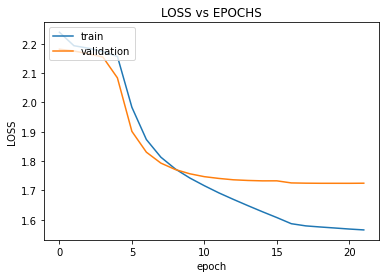

In [89]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

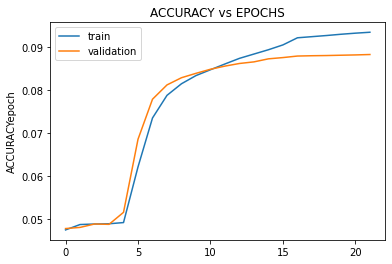

In [90]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [91]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',greedy_search_predict([i]))

question--> hello
BOT--> ['is', 'not', 'it', '<end>']
question--> how are you
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', '<end>']
question--> once upon a  time there was a man
BOT--> ['is', 'not', 'a', 'good', 'time', '<end>']
question--> are you sure you will be alright
BOT--> ['is', 'not', 'a', 'good', 'time', '<end>']
question--> are you coming with me to London
BOT--> ['is', 'not', 'a', 'good', 'time', '<end>']
question--> do you know me
BOT--> ['is', 'not', 'it', '<end>']


In [92]:
from  nltk.translate.bleu_score import sentence_bleu
val=train.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
     
     candidate=greedy_search_predict([val['questions'].iloc[i]])
     reference=[val['answers_out'].iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

The average BLEU score of these sentences is 0.3864459398290385


<h2> MODEL4-  pretrained vector(GLOVE VECTOR) and using function 'dot' for attention</h2>

In [25]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2021-10-21 04:43:08--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2021-10-21 04:43:08--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc56ca05b58a26d4189f8e4d2b94.dl.dropboxusercontent.com/cd/0/inline/BYZ9dA-UuPE1YFhchnWX1CuYyTZdx7L4uBA82TrwlbNnUBcM4rd13TspyJC_WIULfY7qailUCQxYWQrWM11_hA6p2HCBvEqvSoaekxyzCXJEIB9590c82z_bM-sy49DEpms4tIfiAcW3UYVqO0KBn7sp/file# [following]
--2021-10-21 04:43:08--  https://uc56ca05b58a26d4189f8e4d2b94.dl.dropboxusercontent.com/cd/0/inline/BYZ9dA-UuPE1YFhchnWX1CuYyTZdx7L4uBA82TrwlbNnUBcM4rd13TspyJC_WIULfY7qailUCQx

In [26]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix_encoder = np.zeros((VOCAB_SIZE+1, 100))
for word, i in encoder_token.word_index.items():
   if i<VOCAB_SIZE:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix_encoder[i] = embedding_vector

embedding_matrix_decoder = np.zeros((VOCAB_SIZE+1, 100))

for word, i in decoder_token.word_index.items():
  if i<VOCAB_SIZE:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix_decoder[i] = embedding_vector

In [101]:
enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE 

enc_lstm_size=256
dec_lstm_size=512
score_fun='dot'
att_units=512
embedding_weights_available=True
embedding_size=100
enc_input_length=max_length
dec_input_length=max_length
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
#reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.2, patience=2, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
model  = encoder_decoder(enc_vocab_size=enc_vocab_size,dec_vocab_size=dec_vocab_size, embedding_size=embedding_size, enc_lstm_size=enc_lstm_size, dec_lstm_size=dec_lstm_size,  enc_input_length=enc_input_length, dec_input_length=dec_input_length, score_fun=score_fun, att_units=att_units, embedding_weights_available=embedding_weights_available)
optimizer = tf.keras.optimizers.Adam( 0.001,decay=1e-5)
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=['acc'])
#train_steps=train.shape[0]//batch_size
#valid_steps=validation.shape[0]//batch_size

history=model.fit(train_dataset,epochs=100,batch_size=256, validation_data=validation_dataset,callbacks=[reduce_lr,early_stop])
#history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using pretrained vector for embedding
Epoch 1/100
483/483 [==============================] - 378s 445ms/step - loss: 2.2268 - acc: 0.0476 - val_loss: 2.1796 - val_acc: 0.0481
Epoch 2/100
483/483 [==============================] - 180s 373ms/step - loss: 2.1811 - acc: 0.0497 - val_loss: 2.1349 - val_acc: 0.0506
Epoch 3/100
483/483 [==============================] - 180s 373ms/step - loss: 2.1017 - acc: 0.0551 - val_loss: 1.9571 - val_acc: 0.0650
Epoch 4/100
483/483 [==============================] - 180s 374ms/step - loss: 1.9560 - acc: 0.0655 - val_loss: 1.8614 - val_acc: 0.0732
Epoch 5/100
483/483 [==============================] - 180s 372ms/step - loss: 1.8920 - acc: 0.0703 - val_loss: 1.8188 - val_acc: 0.0764
Epoch 6/100
483/483 [==============================] - 180s 372ms/step - loss: 1.8521 - acc: 0.0729 - val_loss: 1.7916 - val_acc: 0.0786
Epoch 7/100
483/483 [==============================] - 180s 374ms/step - loss: 1.8216 - acc: 0.0748 - val_loss: 1.7726 - val_acc: 0.0800
Epo

[]

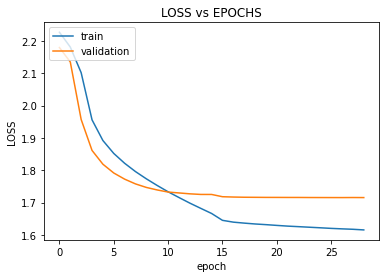

In [102]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

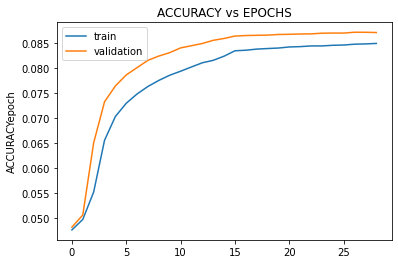

In [103]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [104]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',greedy_search_predict([i]))

question--> hello
BOT--> ['i', 'am', 'sorry', '<end>']
question--> how are you
BOT--> ['i', 'am', 'sorry', '<end>']
question--> once upon a  time there was a man
BOT--> ['i', 'am', 'sorry', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'am', 'sorry', '<end>']
question--> are you coming with me to London
BOT--> ['is', 'she', '<end>']
question--> do you know me
BOT--> ['<end>']


In [105]:
from  nltk.translate.bleu_score import sentence_bleu
val=train.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
     
     candidate=greedy_search_predict([val['questions'].iloc[i]])
     reference=[val['answers_out'].iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

The average BLEU score of these sentences is 0.33210343809668563


<h2> MODEL5-  pretrained vector(GLOVE VECTOR) and using function 'general' for attention</h2>

In [106]:
enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE 

enc_lstm_size=256
dec_lstm_size=512
score_fun='general'
att_units=512
embedding_weights_available=True
embedding_size=100
enc_input_length=max_length
dec_input_length=max_length
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
#reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.2, patience=2, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
model  = encoder_decoder(enc_vocab_size=enc_vocab_size,dec_vocab_size=dec_vocab_size, embedding_size=embedding_size, enc_lstm_size=enc_lstm_size, dec_lstm_size=dec_lstm_size,  enc_input_length=enc_input_length, dec_input_length=dec_input_length, score_fun=score_fun, att_units=att_units, embedding_weights_available=embedding_weights_available)
optimizer = tf.keras.optimizers.Adam( 0.001,decay=1e-5)
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=['acc'])
#train_steps=train.shape[0]//batch_size
#valid_steps=validation.shape[0]//batch_size

history=model.fit(train_dataset,epochs=100,batch_size=256, validation_data=validation_dataset,callbacks=[reduce_lr,early_stop])
#history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using pretrained vector for embedding
Epoch 1/100
483/483 [==============================] - 443s 583ms/step - loss: 2.2269 - acc: 0.0476 - val_loss: 2.1826 - val_acc: 0.0479
Epoch 2/100
483/483 [==============================] - 245s 507ms/step - loss: 2.1954 - acc: 0.0489 - val_loss: 2.1672 - val_acc: 0.0504
Epoch 3/100
483/483 [==============================] - 245s 507ms/step - loss: 2.1447 - acc: 0.0518 - val_loss: 2.0070 - val_acc: 0.0606
Epoch 4/100
483/483 [==============================] - 244s 506ms/step - loss: 1.9831 - acc: 0.0632 - val_loss: 1.8768 - val_acc: 0.0721
Epoch 5/100
483/483 [==============================] - 244s 506ms/step - loss: 1.8994 - acc: 0.0695 - val_loss: 1.8231 - val_acc: 0.0759
Epoch 6/100
483/483 [==============================] - 244s 505ms/step - loss: 1.8532 - acc: 0.0726 - val_loss: 1.7941 - val_acc: 0.0782
Epoch 7/100
483/483 [==============================] - 244s 505ms/step - loss: 1.8196 - acc: 0.0748 - val_loss: 1.7731 - val_acc: 0.0799
Epo

[]

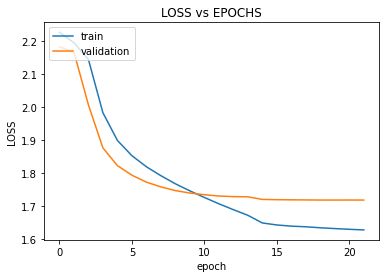

In [107]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

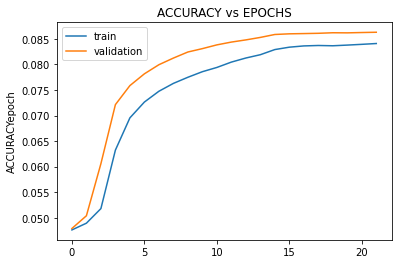

In [108]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [109]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',greedy_search_predict([i]))

question--> hello
BOT--> ['<end>']
question--> how are you
BOT--> ['i', 'am', 'not', 'sure', 'i', 'am', 'not', 'going', 'to', 'be', '<end>']
question--> once upon a  time there was a man
BOT--> ['i', 'am', 'not', 'sure', 'i', 'am', 'not', 'sure', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'do', 'not', 'know', '<end>']
question--> are you coming with me to London
BOT--> ['i', 'do', 'not', 'know', '<end>']
question--> do you know me
BOT--> ['i', 'do', 'not', 'know', '<end>']


In [110]:
from  nltk.translate.bleu_score import sentence_bleu
val=train.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
     
     candidate=greedy_search_predict([val['questions'].iloc[i]])
     reference=[val['answers_out'].iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

The average BLEU score of these sentences is 0.3643019492345212


<h2> MODEL5-  pretrained vector(GLOVE VECTOR) and using function 'concat' for attention</h2>

In [27]:
enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE 

enc_lstm_size=256
dec_lstm_size=512
score_fun='concat'
att_units=512
embedding_weights_available=True
embedding_size=100
enc_input_length=max_length
dec_input_length=max_length
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
#reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.2, patience=2, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
model  = encoder_decoder(enc_vocab_size=enc_vocab_size,dec_vocab_size=dec_vocab_size, embedding_size=embedding_size, enc_lstm_size=enc_lstm_size, dec_lstm_size=dec_lstm_size,  enc_input_length=enc_input_length, dec_input_length=dec_input_length, score_fun=score_fun, att_units=att_units, embedding_weights_available=embedding_weights_available)
optimizer = tf.keras.optimizers.Adam( 0.001,decay=1e-5)
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=['acc'])
#train_steps=train.shape[0]//batch_size
#valid_steps=validation.shape[0]//batch_size

history=model.fit(train_dataset,epochs=100,batch_size=256, validation_data=validation_dataset,callbacks=[reduce_lr,early_stop])
#history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using pretrained vector for embedding
Epoch 1/100
483/483 [==============================] - 382s 553ms/step - loss: 2.2262 - acc: 0.0474 - val_loss: 2.1833 - val_acc: 0.0489
Epoch 2/100
483/483 [==============================] - 237s 491ms/step - loss: 2.1912 - acc: 0.0490 - val_loss: 2.1651 - val_acc: 0.0505
Epoch 3/100
483/483 [==============================] - 237s 490ms/step - loss: 2.1167 - acc: 0.0535 - val_loss: 1.9741 - val_acc: 0.0639
Epoch 4/100
483/483 [==============================] - 236s 490ms/step - loss: 1.9621 - acc: 0.0647 - val_loss: 1.8666 - val_acc: 0.0732
Epoch 5/100
483/483 [==============================] - 236s 490ms/step - loss: 1.8901 - acc: 0.0701 - val_loss: 1.8192 - val_acc: 0.0768
Epoch 6/100
483/483 [==============================] - 237s 490ms/step - loss: 1.8466 - acc: 0.0729 - val_loss: 1.7911 - val_acc: 0.0791
Epoch 7/100
483/483 [==============================] - 236s 490ms/step - loss: 1.8150 - acc: 0.0747 - val_loss: 1.7715 - val_acc: 0.0807
Epo

[]

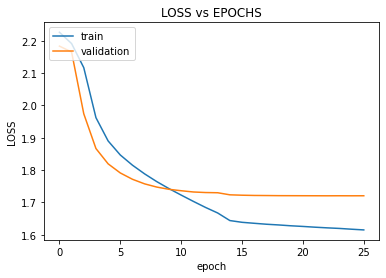

In [28]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

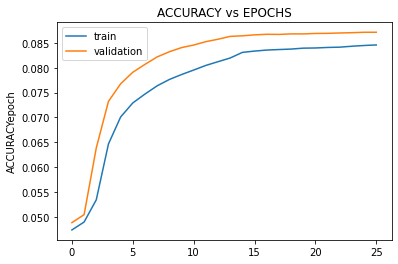

In [29]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [32]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',greedy_search_predict([i]))

question--> hello
BOT--> ['i', 'am', 'sorry', '<end>']
question--> how are you
BOT--> ['i', 'am', 'not', 'a', 'little', 'man', '<end>']
question--> once upon a  time there was a man
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'here', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'am', 'not', 'sure', 'i', 'am', 'not', '<end>']
question--> are you coming with me to London
BOT--> ['i', 'am', 'not', 'sure', 'i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', 'bit', '<end>']
question--> do you know me
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', 'bit', '<end>']


In [33]:
from  nltk.translate.bleu_score import sentence_bleu
val=train.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
     
     candidate=greedy_search_predict([val['questions'].iloc[i]])
     reference=[val['answers_out'].iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The average BLEU score of these sentences is 0.34044292578752594


<h2> MODEL7-  pretrained vector(FASTTEXT VECTOR) and using function 'dot' for attention</h2>

In [34]:
!wget --header="Host: dl.fbaipublicfiles.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mt;q=0.8,hi;q=0.7" --header="Referer: https://colab.research.google.com/" "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip" -c -O 'wiki-news-300d-1M.vec.zip'

--2021-10-21 06:59:12--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  38.8MB/s    in 17s     

2021-10-21 06:59:30 (37.6 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [35]:
!unzip wiki-news-300d-1M.vec.zip 


Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [36]:
import io
fname='wiki-news-300d-1M.vec'
fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
n, d = map(int, fin.readline().split())

In [37]:
lines=fin.readlines()
len(lines)

999994

In [38]:
words_fasttext=[]
for i in lines[1:]:
    words_fasttext.append(i.split()[0])

In [39]:
#EXTRACTION of Pretrained FASTTEXT vectors of 300 dimensions trained on Wikipedia


embedding_matrix_encoder = np.zeros((VOCAB_SIZE+1, 300))

for word, i in encoder_token.word_index.items():
  if i <VOCAB_SIZE:
      if word in words_fasttext:
        embedding_vector = lines[words_fasttext.index(word)+1].split()[1:]
        if embedding_vector is not None:
              embedding_matrix_encoder[i] = embedding_vector

embedding_matrix_decoder = np.zeros((VOCAB_SIZE+1, 300))
for word, i in decoder_token.word_index.items():
  if i<VOCAB_SIZE:
      if word in words_fasttext:
        embedding_vector = lines[words_fasttext.index(word)+1].split()[1:]
        if embedding_vector is not None:
              embedding_matrix_decoder[i] = embedding_vector

In [40]:
from tensorflow.keras import backend
backend.clear_session()

In [41]:
enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE 

enc_lstm_size=256
dec_lstm_size=512
score_fun='dot'
att_units=512
embedding_weights_available=True
embedding_size=300
enc_input_length=max_length
dec_input_length=max_length
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
#reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.2, patience=2, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
model  = encoder_decoder(enc_vocab_size=enc_vocab_size,dec_vocab_size=dec_vocab_size, embedding_size=embedding_size, enc_lstm_size=enc_lstm_size, dec_lstm_size=dec_lstm_size,  enc_input_length=enc_input_length, dec_input_length=dec_input_length, score_fun=score_fun, att_units=att_units, embedding_weights_available=embedding_weights_available)
optimizer = tf.keras.optimizers.Adam( 0.001,decay=1e-5)
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=['acc'])
#train_steps=train.shape[0]//batch_size
#valid_steps=validation.shape[0]//batch_size

history=model.fit(train_dataset,epochs=100,batch_size=256, validation_data=validation_dataset,callbacks=[reduce_lr,early_stop])
#history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using pretrained vector for embedding
Epoch 1/100
483/483 [==============================] - 307s 414ms/step - loss: 2.2284 - acc: 0.0473 - val_loss: 2.1844 - val_acc: 0.0489
Epoch 2/100
483/483 [==============================] - 171s 355ms/step - loss: 2.1947 - acc: 0.0487 - val_loss: 2.1804 - val_acc: 0.0489
Epoch 3/100
483/483 [==============================] - 171s 355ms/step - loss: 2.1659 - acc: 0.0505 - val_loss: 2.1150 - val_acc: 0.0529
Epoch 4/100
483/483 [==============================] - 171s 354ms/step - loss: 2.0344 - acc: 0.0606 - val_loss: 1.9084 - val_acc: 0.0710
Epoch 5/100
483/483 [==============================] - 171s 354ms/step - loss: 1.9109 - acc: 0.0701 - val_loss: 1.8364 - val_acc: 0.0764
Epoch 6/100
483/483 [==============================] - 171s 354ms/step - loss: 1.8539 - acc: 0.0739 - val_loss: 1.8003 - val_acc: 0.0791
Epoch 7/100
483/483 [==============================] - 171s 354ms/step - loss: 1.8155 - acc: 0.0763 - val_loss: 1.7771 - val_acc: 0.0811
Epo

[]

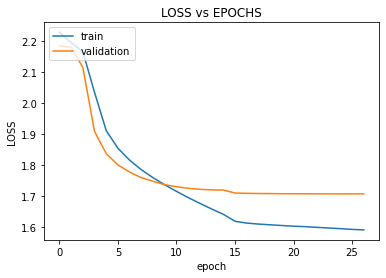

In [42]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

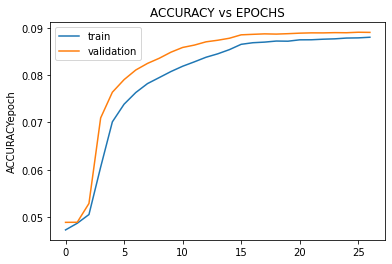

In [43]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [44]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',greedy_search_predict([i]))

question--> hello
BOT--> ['i', 'am', 'sorry', '<end>']
question--> how are you
BOT--> ['<end>']
question--> once upon a  time there was a man
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', '<end>']
question--> are you coming with me to London
BOT--> ['you', 'are', 'not', 'going', 'to', 'do', 'it', '<end>']
question--> do you know me
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', '<end>']


In [45]:
from  nltk.translate.bleu_score import sentence_bleu
val=train.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
     
     candidate=greedy_search_predict([val['questions'].iloc[i]])
     reference=[val['answers_out'].iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The average BLEU score of these sentences is 0.42598427633387304


<h2> MODEL8-  pretrained vector(FASTTEXT VECTOR) and using function 'general' for attention</h2>

In [46]:
backend.clear_session()
enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE 

enc_lstm_size=256
dec_lstm_size=512
score_fun='general'
att_units=512
embedding_weights_available=True
embedding_size=300
enc_input_length=max_length
dec_input_length=max_length
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
#reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.2, patience=2, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
model  = encoder_decoder(enc_vocab_size=enc_vocab_size,dec_vocab_size=dec_vocab_size, embedding_size=embedding_size, enc_lstm_size=enc_lstm_size, dec_lstm_size=dec_lstm_size,  enc_input_length=enc_input_length, dec_input_length=dec_input_length, score_fun=score_fun, att_units=att_units, embedding_weights_available=embedding_weights_available)
optimizer = tf.keras.optimizers.Adam( 0.001,decay=1e-5)
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=['acc'])
#train_steps=train.shape[0]//batch_size
#valid_steps=validation.shape[0]//batch_size

history=model.fit(train_dataset,epochs=100,batch_size=256, validation_data=validation_dataset,callbacks=[reduce_lr,early_stop])
#history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using pretrained vector for embedding
Epoch 1/100
483/483 [==============================] - 379s 544ms/step - loss: 2.2304 - acc: 0.0473 - val_loss: 2.1850 - val_acc: 0.0488
Epoch 2/100
483/483 [==============================] - 232s 481ms/step - loss: 2.1954 - acc: 0.0487 - val_loss: 2.1803 - val_acc: 0.0489
Epoch 3/100
483/483 [==============================] - 232s 481ms/step - loss: 2.1609 - acc: 0.0512 - val_loss: 2.1200 - val_acc: 0.0530
Epoch 4/100
483/483 [==============================] - 234s 485ms/step - loss: 2.0712 - acc: 0.0589 - val_loss: 1.9366 - val_acc: 0.0692
Epoch 5/100
483/483 [==============================] - 234s 484ms/step - loss: 1.9280 - acc: 0.0692 - val_loss: 1.8469 - val_acc: 0.0757
Epoch 6/100
483/483 [==============================] - 234s 484ms/step - loss: 1.8645 - acc: 0.0735 - val_loss: 1.8089 - val_acc: 0.0786
Epoch 7/100
483/483 [==============================] - 233s 483ms/step - loss: 1.8248 - acc: 0.0762 - val_loss: 1.7823 - val_acc: 0.0809
Epo

[]

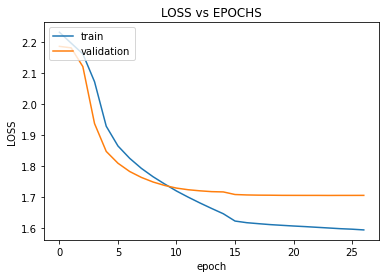

In [47]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

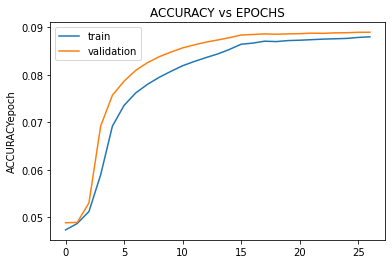

In [48]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [49]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',greedy_search_predict([i]))

question--> hello
BOT--> ['<end>']
question--> how are you
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', 'one', '<end>']
question--> once upon a  time there was a man
BOT--> ['i', 'am', 'sorry', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'do', 'not', 'know', '<end>']
question--> are you coming with me to London
BOT--> ['i', 'do', 'not', 'know', '<end>']
question--> do you know me
BOT--> ['i', 'do', 'not', 'know', '<end>']


In [50]:
from  nltk.translate.bleu_score import sentence_bleu
val=train.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
     
     candidate=greedy_search_predict([val['questions'].iloc[i]])
     reference=[val['answers_out'].iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The average BLEU score of these sentences is 0.34342730279126676


<h2> MODEL9-  pretrained vector(FASTTEXT VECTOR) and using function 'concat' for attention</h2>

In [51]:
enc_vocab_size=VOCAB_SIZE
dec_vocab_size=VOCAB_SIZE 

enc_lstm_size=256
dec_lstm_size=512
score_fun='concat'
att_units=512
embedding_weights_available=True
embedding_size=300
enc_input_length=max_length
dec_input_length=max_length
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.1, patience=1, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
#reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor= 0.2, patience=2, verbose=1,mode='min', min_delta=0.001, cooldown=0, min_lr=0.0001)
model  = encoder_decoder(enc_vocab_size=enc_vocab_size,dec_vocab_size=dec_vocab_size, embedding_size=embedding_size, enc_lstm_size=enc_lstm_size, dec_lstm_size=dec_lstm_size,  enc_input_length=enc_input_length, dec_input_length=dec_input_length, score_fun=score_fun, att_units=att_units, embedding_weights_available=embedding_weights_available)
optimizer = tf.keras.optimizers.Adam( 0.001,decay=1e-5)
model.compile(optimizer=optimizer, loss=custom_lossfunction, metrics=['acc'])
#train_steps=train.shape[0]//batch_size
#valid_steps=validation.shape[0]//batch_size

history=model.fit(train_dataset,epochs=100,batch_size=256, validation_data=validation_dataset,callbacks=[reduce_lr,early_stop])
#history=model.fit(train_dataloader,steps_per_epoch=train_steps,epochs=100, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[reduce_lr,early_stop])
model.summary()

using pretrained vector for embedding
Epoch 1/100
483/483 [==============================] - 386s 555ms/step - loss: 2.2295 - acc: 0.0471 - val_loss: 2.1847 - val_acc: 0.0483
Epoch 2/100
483/483 [==============================] - 240s 496ms/step - loss: 2.1946 - acc: 0.0486 - val_loss: 2.1806 - val_acc: 0.0489
Epoch 3/100
483/483 [==============================] - 239s 496ms/step - loss: 2.1888 - acc: 0.0488 - val_loss: 2.1751 - val_acc: 0.0489
Epoch 4/100
483/483 [==============================] - 240s 497ms/step - loss: 2.1824 - acc: 0.0488 - val_loss: 2.1707 - val_acc: 0.0487
Epoch 5/100
483/483 [==============================] - 240s 497ms/step - loss: 2.1765 - acc: 0.0489 - val_loss: 2.1631 - val_acc: 0.0490
Epoch 6/100
483/483 [==============================] - 240s 497ms/step - loss: 2.1667 - acc: 0.0491 - val_loss: 2.1520 - val_acc: 0.0491
Epoch 7/100
483/483 [==============================] - 240s 497ms/step - loss: 2.0426 - acc: 0.0581 - val_loss: 1.8969 - val_acc: 0.0708
Epo

[]

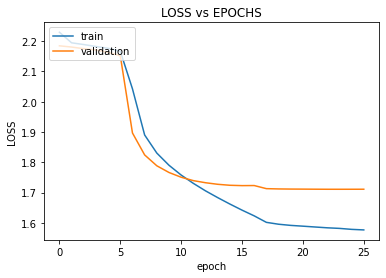

In [52]:
#print history loss validation and training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('LOSS')
plt.xlabel('epoch')
plt.title('LOSS vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

[]

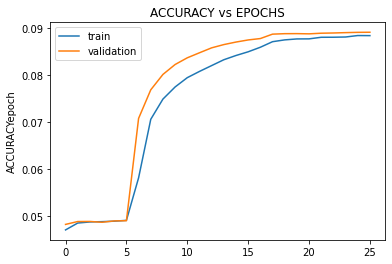

In [53]:
#print history accuracy validation and training
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('ACCURACYepoch')
plt.title('ACCURACY vs EPOCHS')
plt.legend(['train', 'validation'], loc='upper left')
plt.plot()

In [54]:
input_sentence=['hello',
                'how are you',
                'once upon a  time there was a man',
                'are you sure you will be alright',
                'are you coming with me to London',
                'do you know me']
for i in input_sentence:
    print('question-->',i)
    print('BOT-->',greedy_search_predict([i]))

question--> hello
BOT--> ['i', 'am', 'sorry', '<end>']
question--> how are you
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', '<end>']
question--> once upon a  time there was a man
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', 'man', '<end>']
question--> are you sure you will be alright
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'cop', '<end>']
question--> are you coming with me to London
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', '<end>']
question--> do you know me
BOT--> ['i', 'am', 'not', 'going', 'to', 'be', 'a', 'little', '<end>']


In [55]:
from  nltk.translate.bleu_score import sentence_bleu
val=train.sample(1000)
predicted=[]
references=[]
bleu=[]
for i in range(1000):
     
     candidate=greedy_search_predict([val['questions'].iloc[i]])
     reference=[val['answers_out'].iloc[i].split()]
     bleu.append(sentence_bleu(reference,candidate,weights=[0.25,0.25,0.25,0.25]))
bleu_score=np.mean(bleu)
print("The average BLEU score of these sentences is", bleu_score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


The average BLEU score of these sentences is 0.4711586280315582


<h2> OBSERVATION </h2>

We can see that all the models are roughly performing the same, but embedding layer pretrained on fasttext vector and using concat function for attention layer performs the best
